# Monte Carlo
- Documentation: https://gymnasium.farama.org/environments/toy_text/blackjack/
- Your task is to fill all '# TODO' sections, so the Notebook can run from top to bottom
- Your allowed to edit any given code, but I recommend to use the existing structures
- Have a look to the existing outputs. Your outputs should have a simillar structure

### Prerequisites
- Install packages maplotlib

In [2]:
import time
import numpy
import random
import datetime
import gymnasium
import matplotlib
import gymnasium.envs.toy_text.frozen_lake
from typing import Callable, NamedTuple, SupportsFloat
numpy.set_printoptions(precision=4)

### The environment

In [3]:
def CreateEnvironment(render : bool = False) -> gymnasium.Env:
    """Creates the environment were an agent can interact with"""
    renderMode ="human" if render else None
    environment = gymnasium.make('Blackjack-v1', natural=False, sab=False, render_mode=renderMode)
    return environment

def PolicyRandom(env: gymnasium.Env) -> int:
    """Chooses the next action completly randomly"""
    return env.action_space.sample()

def SampleWinRate(env: gymnasium.Env, policy: Callable[[any], int], sampleCount: int = 10_000):
    """Estimates the winrate of the given policy"""
    env = CreateEnvironment(False)
    allReturns = 0
    for _ in range(sampleCount):
        state, info = env.reset()
        while(True):
            action = policy(state)
            state, reward, terminated, truncated, info = env.step(action)
            terminal = terminated or truncated
            allReturns += reward
            if terminal:
                break
    return ((allReturns / sampleCount) * 0.5 + 0.5) * 100

env = CreateEnvironment()
winRate = SampleWinRate(env, lambda s: PolicyRandom(env), 10_000)
print(f'Random win rate: ~{winRate:.2f}%')

Random win rate: ~30.64%


### Agent behaviour

In [94]:
class Agent:
    """Manages all data and behaviour to interact within a environment"""

    ActionValueTable : numpy.ndarray
    """Holds the estimates or return for each possible state-action pair"""

    GymEnv : gymnasium.Env
    """Envornment where the agent is attached to"""

    def __init__(self, env: gymnasium.Env, tableShape: tuple):
        """Initializes the state value table and sets the environment"""
        self.ActionValueTable = numpy.zeros(tableShape)
        self.CountsTable = numpy.zeros(tableShape)
        self.GymEnv = env

    def PolicyGreedy(self, state: tuple) -> int:
        """Chooses the next best action"""

        # TODO Implement a greedy policy
        # TODO Choose randomly on ties
    
        # Get all action values for this state
        # print('action value table:')
        # print(self.ActionValueTable)

        


        action_values = self.ActionValueTable[state][0][:]
        # print('action values:')
        # print(action_values)
        
        
        # Find all actions with the maximum value
        max_value = numpy.max(action_values)
        # print("max value")
        # print(max_value)

        best_actions = numpy.where(action_values == max_value)[0]
        
        # print('best actions:')
        # print(best_actions)
        
        # Randomly choose among tied best actions
        return numpy.random.choice(best_actions)

    def PolicyEpsilon(self, state: tuple, epsilon: float) -> int:
        """May chooses the next action geedy or randomly"""

        # TODO Return a random action with the probability of 'epsilon'
        if numpy.random.random() < epsilon:
            # Use the existing PolicyRandom function for exploration
            return PolicyRandom(self.GymEnv)
        else:
            # Use greedy policy for exploitation
            return self.PolicyGreedy(state)

In [91]:
# Create the agent with the correct table shape for Blackjack
env = CreateEnvironment()
agent = Agent(env, tableShape=(32,11,2,2,2))
# Test policies
state = (1, 0, 0)  # Example state

#print(agent.ActionValueTable[1])
agent.ActionValueTable[state][0][1]=5
agent.ActionValueTable[state][0][0]=5
# print('after editing:')

# print(agent.ActionValueTable[state])
# agent.ActionValueTable[state][:][0]

    
print("Greedy action from greedy policy:", agent.PolicyGreedy(state))
# print("Greedy action from policy epsilon:", agent.PolicyEpsilon(state,0.1))

action values:
[5. 5.]
max value
5.0
best actions:
[0 1]
Greedy action from greedy policy: 0


### Iteration logging

In [95]:
# TODO: Nothing, this only holds and prints data

class StepInfo(NamedTuple):
    """Information about a single step in the environment"""
    State : numpy.ndarray
    Action: int
    Reward : float
    Terminal : bool

class IterateCheckInfo():
    """Holds the current measured performance of sequences"""
    Returns : float = None
    Deltas : float = None

    def Copy(self):
        newInfo = IterateCheckInfo()
        newInfo.Returns = self.Returns
        newInfo.Deltas = self.Deltas
        return newInfo

class IterateInfo:
    """Information about a agent iterating in an environment"""

    def __init__(self, totalSamples: int, checkCount: int = 20):
        """Initializes and setups data based on the desired samples and checkups"""
        self.CheckAtRate = 1.0/100.0
        self.ExponentialChecks = checkCount < 1
        self.TotalSamples = totalSamples
        self.LastStepCheck = time.time()
        self.StartTime = time.time()
        self.CheckAt = 1 if self.ExponentialChecks else max(1, int(totalSamples / checkCount))
        self.CheckAtData = [IterateCheckInfo()]

    def AppendRun(self, runReturn: float):
        """Updates the current run performance only"""
        check = self.CheckAtData[-1]

        if check.Returns is None:
             check.Returns = runReturn
        else:
            diff = runReturn - check.Returns
            check.Returns += diff * self.CheckAtRate

    def AppendStep(self, delta: float, sample: int, onPrint: Callable[[], str] = None):
        """Updates the step performance and may prints the current performance"""
        check = self.CheckAtData[-1]
        delta = abs(delta)

        if check.Deltas is None:
             check.Deltas = delta
        else:
            diff = delta - check.Deltas
            check.Deltas += diff * self.CheckAtRate

        if (sample > 0):
            if (sample % self.CheckAt == 0 or sample == self.TotalSamples):
                def strT(s: float) -> str: return str(datetime.timedelta(seconds=int(s)))

                progress = 100 * (sample / self.TotalSamples)

                runTime = time.time() - self.StartTime
                stepTime = time.time() - self.LastStepCheck

                delta = check.Deltas if check.Deltas != None else 0
                returns = check.Returns if check.Returns != None else float('NaN')

                print(f'{progress:06.2f}% >> 🕗: {strT(runTime)} | {strT(stepTime)} >> 💡: {delta:+.4f} >> 🎮: {returns:0.2f}', end='')
                if (onPrint is not None): print(onPrint(), end='')
                print()

                if (sample < self.TotalSamples):
                    self.CheckAtData.append(self.CheckAtData[-1].Copy())
                    self.LastStepCheck = time.time()
                    if (self.ExponentialChecks): self.CheckAt *= 2

### Naive Monte Carlo implementation

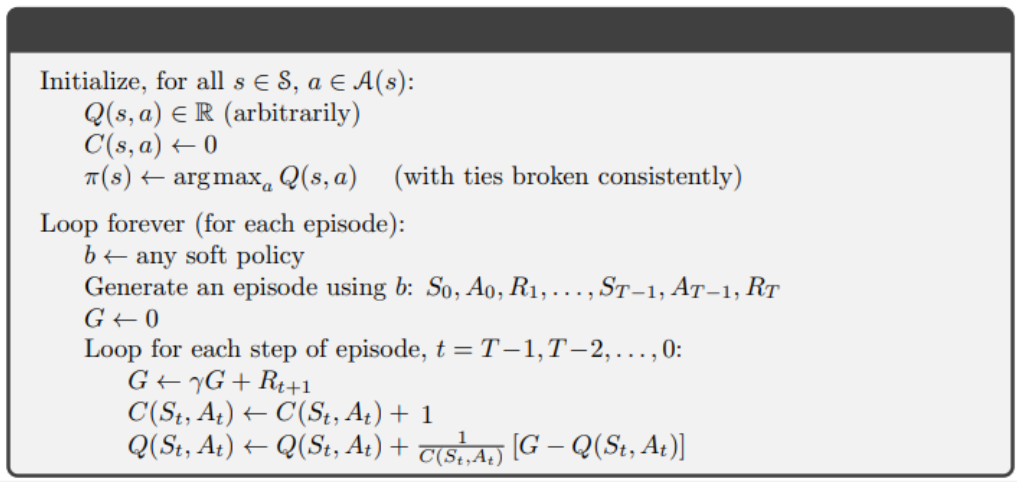

In [98]:
winRates: list[float] = []
def customPrint():
    sampleEnv = CreateEnvironment()
    winRates.append(SampleWinRate(sampleEnv, agent.PolicyGreedy))
    return f' | {winRates[-1]:.2f}'

env = CreateEnvironment(False)
agent = Agent(env, (*[s.n for s in env.observation_space.spaces], env.action_space.n,2))
logs = IterateInfo(250_000, 0)
gamma = 0.95
epsilon = 1.0 / 8.0

sample = 0
while(sample < logs.TotalSamples):
    sequence: list[StepInfo] = []
    state, info = env.reset()
    runReturn = 0  # Total return for this episode

    while(True):
        # TODO let the agent choose the next action
        action = agent.PolicyEpsilon(state, epsilon)
       
        nextState, reward, terminated, truncated, info = env.step(action)
        sequence.append(StepInfo(state, action, reward, terminated))
        state = nextState
        runReturn += reward


        # TODO Implement the algorithm in the picture from above
        # TODO Set the 'change' variable to the change applied to the table.
        # TODO Use the collected data from 'sequence' for evaluation.

        # TODO Print your data:
        #   - Call after every step: 'logs.AppendStep(change, sample, customPrint)'
        #   - Call after sequence end: 'logs.AppendRun(runReturn)'

        if terminated or truncated:
            break
    G = 0
    max_change = 0
    
    # Process collected data from sequence
    for t in reversed(range(len(sequence))):
        step = sequence[t]
        G = gamma * G + step.Reward
        
        # Update Q-table and track changes
        agent.ActionValueTable[step.State][1][step.Action] += 1     #countTable
        alpha = 1 / agent.ActionValueTable[step.State][1][step.Action] #countTable

        
        
        old_value = agent.ActionValueTable[step.State][0][step.Action] #reward table
        

        
        new_value = old_value + alpha * (G - old_value)
        
        agent.ActionValueTable[step.State][0][step.Action] = new_value
        
        current_change = abs(new_value - old_value)
        logs.AppendStep(current_change, sample, customPrint)  # After every step
        
        if current_change > max_change:
            max_change = current_change

    # set change
    change = max_change
    # logs.AppendStep(change, sample, customPrint)  # After every episode
    logs.AppendRun(runReturn)  # Log episode return
    
    sample += 1

000.00% >> 🕗: 0:00:00 | 0:00:00 >> 💡: +1.0000 >> 🎮: 1.00 | 29.91
000.00% >> 🕗: 0:00:01 | 0:00:00 >> 💡: +1.0000 >> 🎮: 0.98 | 30.26
000.00% >> 🕗: 0:00:03 | 0:00:00 >> 💡: +0.9900 >> 🎮: 0.98 | 31.23
000.00% >> 🕗: 0:00:05 | 0:00:00 >> 💡: +0.9904 >> 🎮: 0.93 | 30.19
000.01% >> 🕗: 0:00:07 | 0:00:00 >> 💡: +0.9784 >> 🎮: 0.84 | 31.44
000.01% >> 🕗: 0:00:09 | 0:00:00 >> 💡: +0.9358 >> 🎮: 0.70 | 32.88
000.03% >> 🕗: 0:00:11 | 0:00:00 >> 💡: +0.9347 >> 🎮: 0.41 | 35.23
000.05% >> 🕗: 0:00:13 | 0:00:00 >> 💡: +0.8251 >> 🎮: 0.11 | 37.05
000.10% >> 🕗: 0:00:14 | 0:00:00 >> 💡: +0.6007 >> 🎮: -0.14 | 37.08
000.20% >> 🕗: 0:00:16 | 0:00:00 >> 💡: +0.4024 >> 🎮: -0.31 | 40.20
000.41% >> 🕗: 0:00:18 | 0:00:00 >> 💡: +0.1963 >> 🎮: -0.31 | 42.88
000.82% >> 🕗: 0:00:20 | 0:00:00 >> 💡: +0.1028 >> 🎮: -0.12 | 42.21
001.64% >> 🕗: 0:00:23 | 0:00:00 >> 💡: +0.0632 >> 🎮: -0.21 | 43.99
003.28% >> 🕗: 0:00:26 | 0:00:00 >> 💡: +0.0305 >> 🎮: -0.13 | 45.20
006.55% >> 🕗: 0:00:29 | 0:00:01 >> 💡: +0.0128 >> 🎮: -0.11 | 46.11
013.11% >> 🕗: 0:00

In [101]:
print(agent.ActionValueTable[state][0][0])

0.6543985637342906


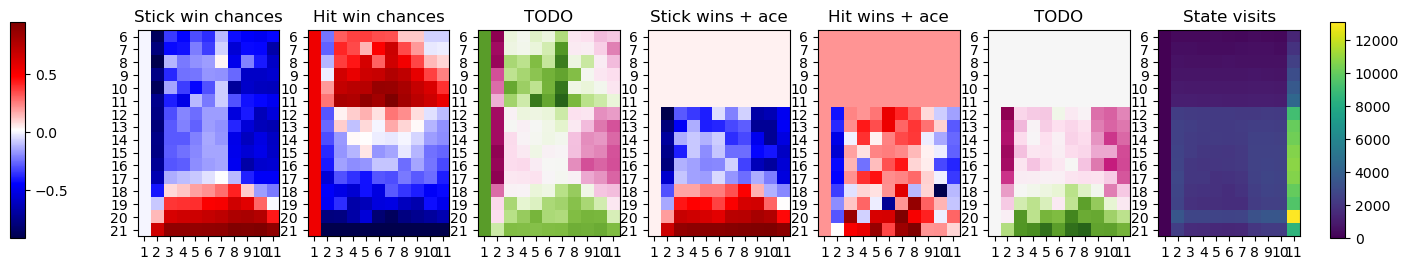

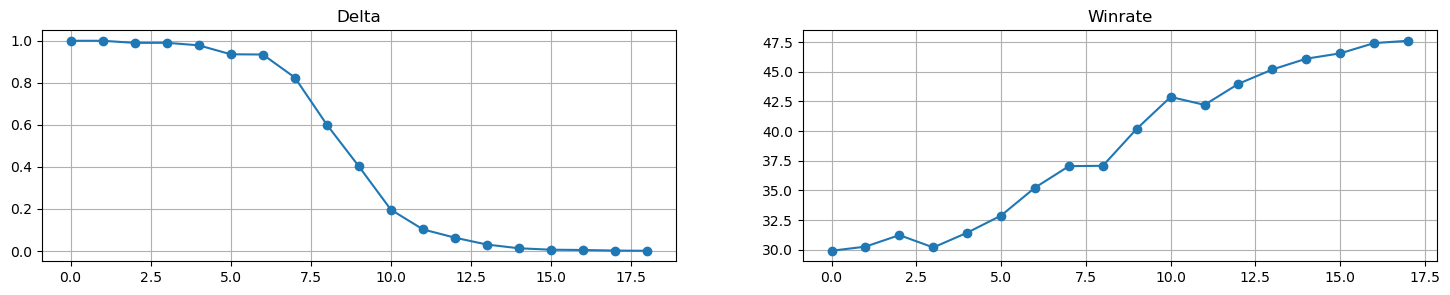

In [111]:
import matplotlib.pyplot as plt

cardRange = slice(6, 22)
xLabels = range(1, 12)
yLabels = range(cardRange.start, cardRange.stop)

tableMaps = [
    # TODO Name each table, choose a name that describes the data shown
    ('Stick win chances', 'seismic', agent.ActionValueTable[cardRange, :, 0, 0, 0]),
    ('Hit win chances', 'seismic', agent.ActionValueTable[cardRange, :, 0, 0, 1]),
    ('TODO', 'PiYG', numpy.average(agent.ActionValueTable[cardRange, :, 0, 0, :], axis=-1)),
    ('Stick wins + ace', 'seismic', agent.ActionValueTable[cardRange, :, 1, 0, 0]),
    ('Hit wins + ace', 'seismic', agent.ActionValueTable[cardRange, :, 1, 0, 1]),
    ('TODO', 'PiYG', numpy.average(agent.ActionValueTable[cardRange, :, 1, 0, :], axis=-1)),
    ('State visits', 'viridis', numpy.sum(agent.ActionValueTable[cardRange, :, :, 1, :], axis=(-1, -2))),
]

ims = []
mapCount = len(tableMaps)
fig, axes = plt.subplots(1, mapCount, figsize=(15, 6))
for i, ax in enumerate(axes):
    im = ax.imshow(tableMaps[i][2], cmap=tableMaps[i][1], aspect='equal')
    ax.set_title(tableMaps[i][0])
    ax.set_xticks(range(len(xLabels)), labels=xLabels)
    ax.set_yticks(range(len(yLabels)), labels=yLabels)
    ims.append(im)

fig.colorbar(ims[0], cax=fig.add_axes([0.04, 0.32, 0.01, 0.36]))
fig.colorbar(ims[-1], cax=fig.add_axes([0.92, 0.32, 0.01, 0.36]))
plt.show()



fig, axes = plt.subplots(1, 2, figsize=(18, 3))
axes[0].set_title('Delta')
axes[0].plot([step.Deltas for step in logs.CheckAtData], marker='o', linestyle='-')
axes[0].grid(True)
axes[1].set_title('Winrate')
axes[1].plot(winRates, marker='o', linestyle='-')
axes[1].grid(True)

plt.grid(True)
plt.show()